<a href="https://colab.research.google.com/github/JustBNM/graph-recommend-system/blob/main/Personalized_RecSys_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка и подключение библиотек

In [7]:
#!pip3 install torch --upgrade
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 4.3 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 3.5 MB 4.0 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 2.5 MB 3.8 MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 750 kB 4.3 MB/s 
     |████████████████████████████████| 407 kB 4.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=08ffbc9f7b6242701289783e6918d8d20a360e4f665e22e9a1e0038b0d577b6d
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [8]:
torch.__version__

'1.11.0+cu113'

In [9]:
!pip install umap
!pip install umap-learn

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=268efeab86b0d42356f2f04c5d99d8b54097e9fb1887db81cb7e433c57c98e18
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap
     |████████████████████████████████| 88 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 10.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=7beb4018c9e0e493ee4082a4aceabb1d9117b4c351f1d109bdb8c1a22f4e0f77
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=a633776cf32f2f0a51302a31181fb9ee9ec9bcdda4bc10c4ad43d926ec6ff808
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [10]:
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression
from torch_cluster import random_walk

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborSampler as RawNeighborSampler
from torch_geometric.nn import SAGEConv

import umap
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

## Датасет

In [11]:
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np

In [57]:
number_of_person = 500
from scipy.special import softmax
genders = np.random.randint(0, 2, number_of_person)
# пиво берут редко
pivo_buy = np.random.choice([0,1], number_of_person, p=[0.8, 0.2])
# любовь к пиву зависит от того, взяли ли его
pivo_love = np.array([pivo*np.random.normal(loc=0.6, scale=0.2, size=1) + 
                      (1 - pivo)*np.random.normal(loc=0.3, scale=0.3, size=1) for pivo in pivo_buy]).squeeze()
# картошка с пивом - хорошо
kartoshka_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.5, 0.4+2*pivo])) for pivo in pivo_love])
kartoshka_love = np.array([prod_buy*np.random.normal(loc=0.6, scale=0.2, size=1) + 
                      (1 - prod_buy)*np.random.normal(loc=0.4, scale=0.3, size=1) for prod_buy in kartoshka_buy]).squeeze()
# салатик берут девушки
salatic_love = np.array([gender*np.random.normal(loc=0.2, scale=0.2, size=1) + 
                      (1 - gender)*np.random.normal(loc=0.4, scale=0.2, size=1) for gender in genders]).squeeze()
salatic_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4+prod])) for prod in salatic_love])
# Пиво с мороженкой плохо заходит
morozenka_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4-prod])) for prod in pivo_buy]).squeeze()
morozenka_love = 1/(0.5 + pivo_love)
cola_love = np.random.random(number_of_person)
burger_love = np.random.random(number_of_person)
# Если купил всего 1 продукт - пусть берёт колу
cola_buy = np.array([np.random.choice([0,1], 1, p=softmax([0.6, 0.4+prod])) for prod in salatic_love])
# Если кроме колы ничего не взял - пусть берёт бургер

df_user = pd.DataFrame()
df_user['gender'] = genders
df_user['pivo_love'] = pivo_love
df_user['kartoshka_love'] = kartoshka_love
df_user['salatic_love'] = salatic_love
df_user['morozenka_love'] = morozenka_love
df_user['cola_love'] = salatic_love
df_user['burger_love'] = morozenka_love


df_user['pivo_buy'] = pivo_buy
df_user['kartoshka_buy'] = kartoshka_buy
df_user['salatic_buy'] = salatic_buy
df_user['morozenka_buy'] = morozenka_buy

cola_buy = np.array(1 if sum(df_user.loc[i, ['pivo_buy', 'kartoshka_buy', 'salatic_buy', 'morozenka_buy']]) <= 1 
                                         else int(np.random.choice([0,1], 1, p=softmax([0.7, 0.3+prod]))) for i, prod in enumerate(cola_love)).squeeze()

df_user['cola_buy'] = cola_buy

burger_buy = np.array(1 if sum(df_user.loc[i, ['pivo_buy', 'kartoshka_buy', 'salatic_buy', 'morozenka_buy']]) == 0 
                                         else int(np.random.choice([0,1], 1, p=softmax([0.7, 0.3+prod]))) for i, prod in enumerate(burger_love)).squeeze()
df_user['burger_buy'] = burger_buy

In [58]:
df_user

,gender,pivo_love,kartoshka_love,salatic_love,morozenka_love,cola_love,burger_love,pivo_buy,kartoshka_buy,salatic_buy,morozenka_buy,cola_buy,burger_buy
0,0,-0.025347,0.457108,0.384018,2.106802,0.384018,2.106802,0,1,0,1,1,0
1,0,0.212670,0.544134,0.576993,1.403174,0.576993,1.403174,0,1,1,0,1,0
2,0,0.623261,0.365899,0.515073,0.890265,0.515073,0.890265,0,1,0,1,1,0
3,0,0.453500,0.297427,0.478465,1.048768,0.478465,1.048768,0,0,0,1,1,1
4,1,0.921927,0.208957,0.308302,0.703271,0.308302,0.703271,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0,-0.000414,0.150221,0.371805,2.001658,0.371805,2.001658,0,0,1,0,1,1
496,0,-0.118612,0.843837,0.051563,2.622004,0.051563,2.622004,0,1,0,0,1,1
497,1,0.188023,0.781894,0.078305,1.453441,0.078305,1.453441,0,1,1,0,0,0
498,0,0.466233,0.731942,0.481617,1.034947,0.481617,1.034947,1,1,1,0,0,0


In [59]:
Counter(df_user.iloc[:, 7:].sum(axis=1))

Counter({2.0: 165, 3.0: 203, 4.0: 97, 5.0: 34, 6.0: 1})

In [60]:
import sklearn.preprocessing as skl
category = ['Пиво','Картошка', 'Салатик', 'Мороженка', 'cola', 'burger']
df_dish = pd.DataFrame(np.eye(6), index = category)

In [61]:
df_dish

,0,1,2,3,4,5
Пиво,1.0,0.0,0.0,0.0,0.0,0.0
Картошка,0.0,1.0,0.0,0.0,0.0,0.0
Салатик,0.0,0.0,1.0,0.0,0.0,0.0
Мороженка,0.0,0.0,0.0,1.0,0.0,0.0
cola,0.0,0.0,0.0,0.0,1.0,0.0
burger,0.0,0.0,0.0,0.0,0.0,1.0


In [62]:
df_user.iloc[:, :7].values

array([[ 0.        , -0.02534686,  0.45710805, ...,  2.10680163,
         0.38401845,  2.10680163],
       [ 0.        ,  0.21267017,  0.54413385, ...,  1.40317364,
         0.57699255,  1.40317364],
       [ 0.        ,  0.62326124,  0.36589858, ...,  0.89026485,
         0.51507327,  0.89026485],
       ...,
       [ 1.        ,  0.1880225 ,  0.78189437, ...,  1.45344083,
         0.07830511,  1.45344083],
       [ 0.        ,  0.46623312,  0.73194222, ...,  1.03494693,
         0.48161674,  1.03494693],
       [ 0.        ,  0.29794284,  0.21433137, ...,  1.2532226 ,
         0.71695774,  1.2532226 ]])

In [63]:
df_user.iloc[:, 7:] = df_user.iloc[:, 7:].astype(int) 

In [64]:
data = HeteroData()
data['user'].x = torch.from_numpy(df_user.iloc[:, 1:7].values)
data['dish'].x = torch.from_numpy(df_dish.values).float()
data['user'].y = torch.from_numpy(df_user.iloc[:, 7:].values)
#data['dish'].y = torch.from_numpy(df_dish.iloc[:, :6].values)

In [65]:
data['dish']

{'x': tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])}

In [66]:
torch_buy_pivo = torch.stack((torch.from_numpy(df_user[df_user.pivo_buy == 1].index.values) , 
                              torch.from_numpy(np.zeros(len(df_user[df_user.pivo_buy == 1].index))) ))

In [67]:
torch_buy_kartoshka = torch.stack((torch.from_numpy(df_user[df_user.kartoshka_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.kartoshka_buy == 1].index))) ))
torch_buy_salatic = torch.stack((torch.from_numpy(df_user[df_user.salatic_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.salatic_buy == 1].index))*2) ))
torch_buy_morozenka = torch.stack((torch.from_numpy(df_user[df_user.morozenka_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.morozenka_buy == 1].index))*3) ))
torch_buy_cola = torch.stack((torch.from_numpy(df_user[df_user.cola_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.cola_buy == 1].index))*4) ))
torch_buy_burger = torch.stack((torch.from_numpy(df_user[df_user.burger_buy == 1].index.values) , 
                                  torch.from_numpy(np.ones(len(df_user[df_user.burger_buy == 1].index))*5) ))

In [68]:
data['user', 'buys', 'dish'].edge_index = torch.cat((torch_buy_pivo, torch_buy_kartoshka, torch_buy_salatic,
                                                     torch_buy_morozenka, torch_buy_cola, torch_buy_burger), axis=1)

In [69]:
data['user'].x = data['user'].x.float()

In [70]:
data['user'].x.type()

'torch.FloatTensor'

In [71]:
data['buys'].edge_index = data['buys'].edge_index.type(torch.LongTensor)

In [72]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1503] }
)

In [73]:
#data = T.ToUndirected()(data)

## Гомограф

In [ ]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
homogeneous_data = data.to_homogeneous()
homogeneous_data.x = homogeneous_data.x.float()

In [ ]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={
    x=[6, 6],
    y=[6, 6]
  },
  (user, buys, dish)={ edge_index=[2, 1521] },
  (dish, rev_buys, user)={ edge_index=[2, 1521] }
)

In [ ]:
homogeneous_data

Data(node_type=[506], x=[506, 6], y=[506, 6], edge_index=[2, 3042], edge_type=[3042])

In [ ]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        # print(batch)
        # print(np.array(self.adj_t).shape)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]
        # print(pos_batch)

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)
        # print(neg_batch)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)


In [ ]:
hetero_data = data

In [ ]:
hetero_data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
#data = homogeneous_data

In [259]:
train_loader = NeighborSampler(homogeneous_data.edge_index, sizes=[1, 1], batch_size=1,
                               shuffle=True, num_nodes=data.num_nodes)

In [ ]:
from torch_geometric.loader import NeighborLoader
n_neigh = 1
loader = NeighborLoader(
    hetero_data,
    # Sample n_neigh neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [n_neigh] * 2 for key in hetero_data.edge_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=1,
    input_nodes=('user'),
)

In [ ]:
hetero_data.edge_types

[('user', 'buys', 'dish'), ('dish', 'rev_buys', 'user')]

In [ ]:
iterator = iter(loader)

In [ ]:
next(iterator)

HeteroData(
  user={
    x=[2, 6],
    y=[2, 6],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [216]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1491] },
  (dish, rev_buys, user)={ edge_index=[2, 1491] }
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)

AttributeError: ignored

In [ ]:
model.train()

total_loss = 0
for batch_size, n_id, adjs in train_loader:
    # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
    adjs = [adj.to(device) for adj in adjs]
    optimizer.zero_grad()

    out = model(x[n_id], adjs)
    out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

    pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
    neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
    loss = -pos_loss - neg_loss
    loss.backward()
    optimizer.step()

    total_loss += float(loss) * out.size(0)
    #break

In [ ]:
def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes

In [ ]:
@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [ ]:
for epoch in range(1, 51):
    loss = train()
    #val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ')
          #f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 3.9374, 
Epoch: 002, Loss: 1.9053, 
Epoch: 003, Loss: 2.5082, 
Epoch: 004, Loss: 1.2902, 
Epoch: 005, Loss: 1.6550, 
Epoch: 006, Loss: 1.3754, 
Epoch: 007, Loss: 1.0893, 
Epoch: 008, Loss: 1.1739, 
Epoch: 009, Loss: 1.1811, 
Epoch: 010, Loss: 12.5970, 
Epoch: 011, Loss: 1.8660, 
Epoch: 012, Loss: 1.4447, 
Epoch: 013, Loss: 1.2702, 
Epoch: 014, Loss: 1.2241, 
Epoch: 015, Loss: 1.1750, 
Epoch: 016, Loss: 1.2588, 
Epoch: 017, Loss: 1.2314, 
Epoch: 018, Loss: 1.5580, 
Epoch: 019, Loss: 1.2436, 
Epoch: 020, Loss: 1.6134, 
Epoch: 021, Loss: 1.4148, 
Epoch: 022, Loss: 1.3466, 
Epoch: 023, Loss: 1.3291, 
Epoch: 024, Loss: 1.7191, 
Epoch: 025, Loss: 1.3414, 
Epoch: 026, Loss: 1.2195, 
Epoch: 027, Loss: 1.1805, 
Epoch: 028, Loss: 1.3871, 
Epoch: 029, Loss: 1.2027, 
Epoch: 030, Loss: 1.2019, 
Epoch: 031, Loss: 1.1076, 
Epoch: 032, Loss: 1.1174, 
Epoch: 033, Loss: 1.2475, 
Epoch: 034, Loss: 1.9446, 
Epoch: 035, Loss: 1.4923, 
Epoch: 036, Loss: 1.3843, 
Epoch: 037, Loss: 1.7037, 


In [ ]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

In [ ]:
np.where(data.y[23].numpy() == 1)

(array([2, 4]),)

In [ ]:
for i in range(6):
  print(sum(data.y[:,i]))

tensor(109., dtype=torch.float64)
tensor(326., dtype=torch.float64)
tensor(260., dtype=torch.float64)
tensor(205., dtype=torch.float64)
tensor(349., dtype=torch.float64)
tensor(278., dtype=torch.float64)


In [ ]:
from numpy import linalg
for j in range(200):
  test = []
  for i in range(200, 206):
    test.append(sum(out[j].numpy() * out[i].numpy()))
  test = np.array(test)
  sorted_indices = sorted(range(len(test)), key=lambda k: test[k], reverse = True)
  # print(sorted_indices)
  # print(np.where(data.y[j].numpy() == 1))
  # print('----')

In [ ]:
# palette = {}

# for n, y in enumerate(set(data.y.numpy())):
#     palette[y] = f'C{n}'

palette = {}

for n, y in enumerate(set(data.y[:,1].numpy())):
    palette[y] = f'C{n}'

In [ ]:
embd = umap.UMAP().fit_transform(out.cpu().numpy())

In [ ]:
sum(data.y[:,0].cpu().numpy() * data.y[:,1].cpu().numpy() * data.y[:,2].cpu().numpy())

46.0

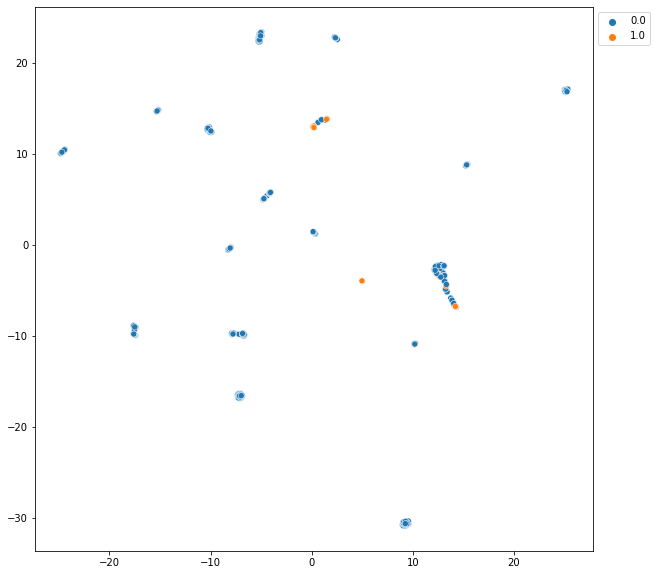

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y[:,0].cpu().numpy() * data.y[:,1].cpu().numpy() * data.y[:,2].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.savefig("umap_embd_sage.png", dpi=120)

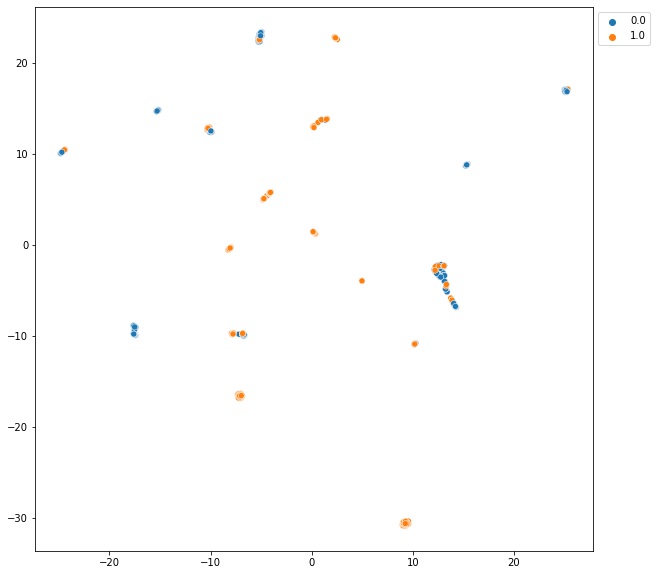

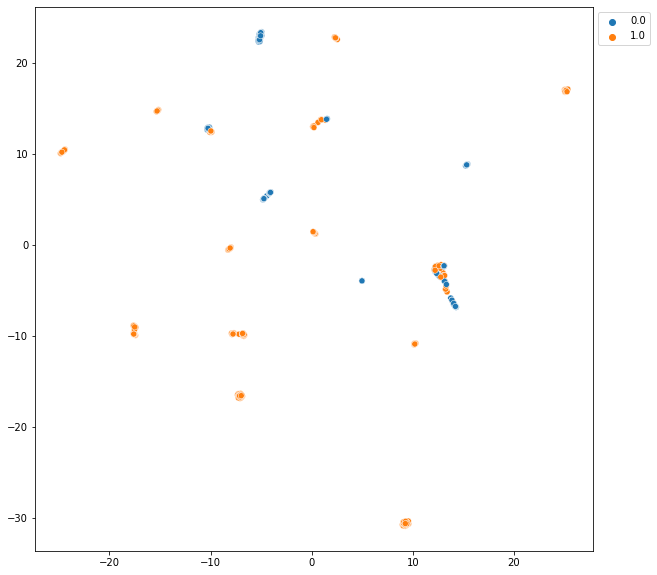

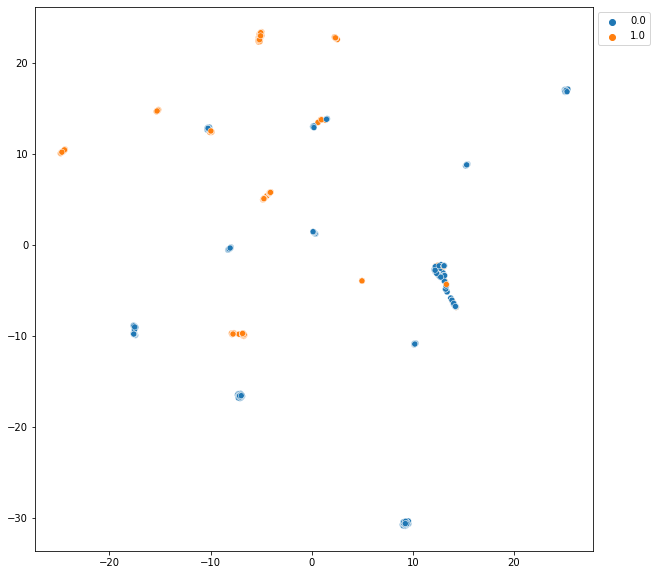

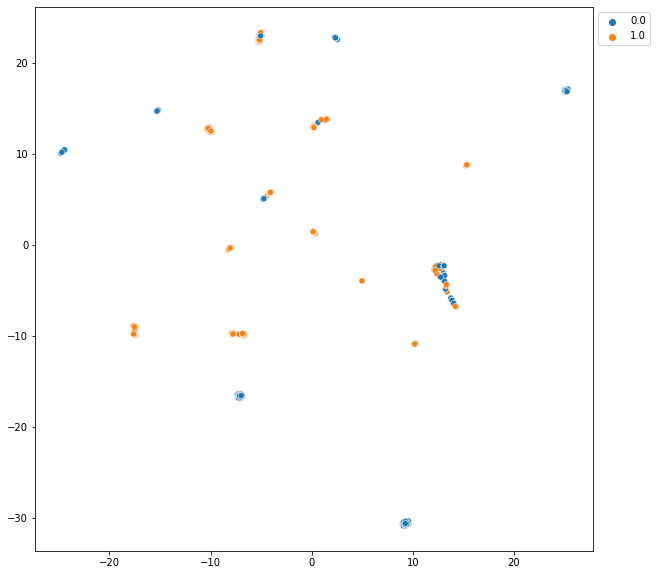

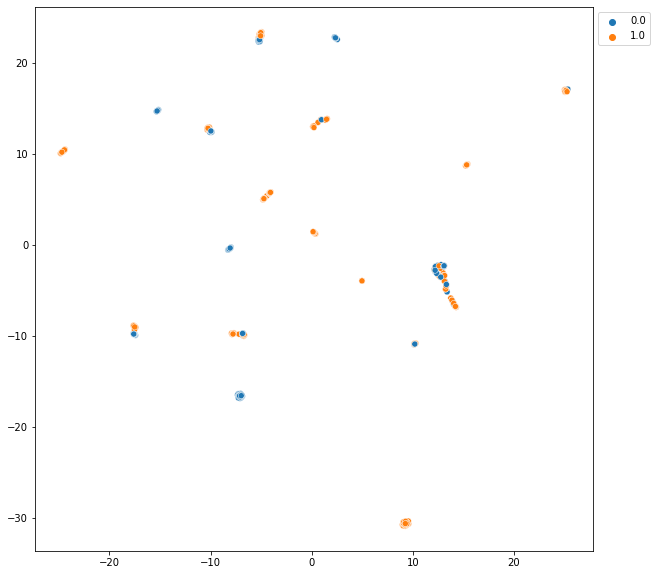

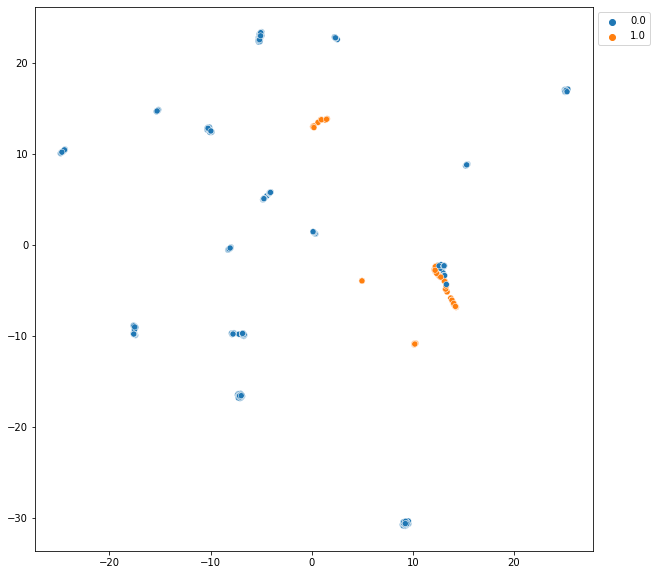

In [ ]:
for i in range(5,-1, -1):
  plt.figure(figsize=(10, 10))
  sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y[:,i].cpu().numpy(), palette=palette)
  plt.legend(bbox_to_anchor=(1,1), loc='upper left')
  #plt.savefig("umap_embd_sage.png", dpi=120)

In [ ]:
embd_x = umap.UMAP().fit_transform(data.x.numpy())

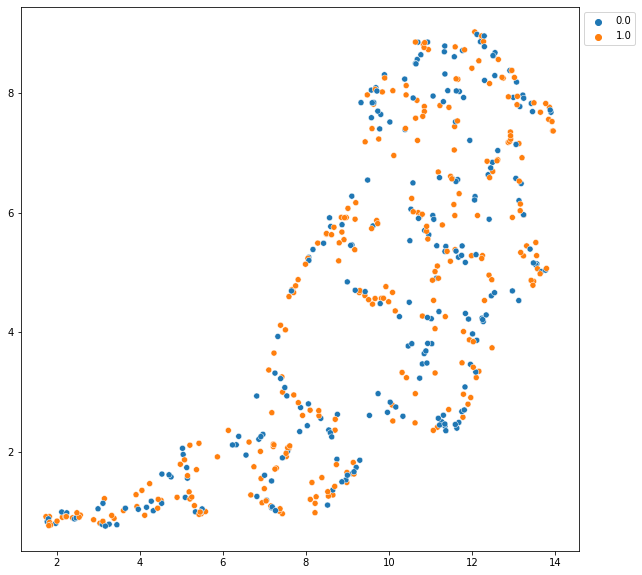

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data.y[:,5].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)

## Гетерограф

In [110]:
hetero_data = data

In [111]:
data['dish']

{'x': tensor([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.]])}

In [24]:
from torch_geometric.loader import NeighborLoader
n_neigh = 1
loader = NeighborLoader(
    hetero_data,
    # Sample n_neigh neighbors for each node and edge type for 2 iterations
    num_neighbors={key: [n_neigh] * 2 for key in hetero_data.edge_types},
    # Use a batch size of 128 for sampling training nodes of type paper
    batch_size=1,
    input_nodes=('user'),
)

In [25]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [26]:
from torch_geometric.nn import SAGEConv, to_hetero

In [114]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


# dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
# data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64)
model = to_hetero(model, data.metadata(), aggr='sum')

/usr/local/lib/python3.7/dist-packages/torch_geometric/nn/to_hetero_transformer.py:139: UserWarning: There exist node types ({'user'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  f"There exist node types ({unused_node_types}) whose "


In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SAGE(data['user'].num_node_features, hidden_channels=64, num_layers=2)
# model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
#x, edge_index = data.x.to(device), data.edge_index.to(device)

### Эксперименты с SparceTensor

In [29]:
from torch_sparse import SparseTensor
edge_index = a[2][0].edge_index
is_sparse_tensor = isinstance(edge_index, SparseTensor)
is_sparse_tensor

NameError: ignored

In [345]:
edge_index

tensor([[3, 4, 5, 6, 7, 8],
        [0, 1, 2, 3, 4, 5]])

In [354]:
SparseTensor(row=torch.tensor([0, 10, 2, 3, 4, 5]), col=torch.tensor([3, 4, 5, 6, 7, 8]))

SparseTensor(row=tensor([ 0,  2,  3,  4,  5, 10]),
             col=tensor([3, 5, 6, 7, 8, 4]),
             size=(11, 9), nnz=6, density=6.06%)

In [290]:
homogeneous_data.edge_index.numpy()[0]

array([  0,   4,   6, ..., 505, 505, 505])

In [275]:
edge_index[0], edge_index[1]

(tensor([3, 4, 5, 6, 7, 8]), tensor([0, 1, 2, 3, 4, 5]))

In [ ]:
pos_batch = random_walk(homogeneous_data.edge_index.numpy()[0], homogeneous_data.edge_index.numpy()[1], batch, walk_length=1,
                                coalesced=False)[:, 1]

In [335]:
random_walk(torch.LongTensor(homogeneous_data.edge_index.numpy()[0]), torch.LongTensor(homogeneous_data.edge_index.numpy()[1]),
            start = torch.LongTensor([353]), walk_length=1, coalesced=False)#[:, 1]

tensor([[353, 504]])

In [261]:
for a in loader:
  print(a)
  break

HeteroData(
  user={
    x=[2, 6],
    y=[2, 6],
    batch_size=1
  },
  dish={ x=[1, 6] },
  (user, buys, dish)={ edge_index=[2, 1] },
  (dish, rev_buys, user)={ edge_index=[2, 1] }
)


### Конец экспериментов

In [30]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in loader:
            optimizer.zero_grad()
            #batch = batch.to('cuda:0')
            batch_size = batch['user'].batch_size
            #print(batch['user'].y)

            out = model(batch.x_dict,
                        batch.edge_index_dict)
            #break

            ### negative sampling
            neg_dish = []
            for element in batch['user'].y[:batch_size]:
              list_ = np.where(element == 0)[0]
              if list_ != []:
                neg_dish.append(np.random.choice(list_))
              else: 
                neg_dish.append(np.random.choice(np.arange(len(element))))
      
            n_neigh = 10
            dish_loader = NeighborLoader(
                hetero_data,
                # Sample n_neigh neighbors for each node and edge type for 2 iterations
                num_neighbors={key: [n_neigh] * 1 for key in hetero_data.edge_types},
                # Use a batch size of 128 for sampling training nodes of type paper
                batch_size=1,
                input_nodes=('dish', torch.Tensor(neg_dish)),
            )
            for dish_batch in dish_loader:
              optimizer.zero_grad()
              #batch = batch.to('cuda:0')
              batch_size = dish_batch['dish'].batch_size

              neg_out = model(dish_batch.x_dict,
                            dish_batch.edge_index_dict)


            # loss = F.cross_entropy(out['paper'][:batch_size],
            #                        batch['paper'].y[:batch_size])
            #print(out['user'][:batch_size])
            pos_loss = F.logsigmoid((out['user'][:batch_size] * out['dish'][:batch_size]).sum(-1)).mean()
            neg_loss = F.logsigmoid(-(out['user'][:batch_size] * neg_out['dish'][:batch_size]).sum(-1)).mean()
            loss = -pos_loss - neg_loss
            loss.backward()
            optimizer.step()

            total_examples += batch_size
            total_loss += float(loss) * batch_size
    return total_loss / total_examples

In [31]:
for _ in range(30):
  loss = train()
  print(loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


1.6924284185171128
1.4841534690260887
1.3604386062026024
1.3295463180541993
1.2287819738835097
1.237514231443405
1.1863479912877082
1.127536418318865
1.1120209171412385
1.0973599194586277
1.0829019178152084
1.0734680273781052
1.1064815532851695
1.016218272715807
0.9966336264908314
0.9926919131278992
0.9590032159085856
0.9332246511351482
0.8724360260966434
0.8047678595711477
0.8715579081434899
0.886527627401054
0.8200214812506746
0.8031903420258314
0.905101034189167
0.7558634213656187
0.6365866472986527
0.7566155146000383
0.6421014458086678
0.643672020615879


In [ ]:
@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc

In [ ]:
for epoch in range(1, 51):
    loss = train()
    #val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ')
          #f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 3.9374, 
Epoch: 002, Loss: 1.9053, 
Epoch: 003, Loss: 2.5082, 
Epoch: 004, Loss: 1.2902, 
Epoch: 005, Loss: 1.6550, 
Epoch: 006, Loss: 1.3754, 
Epoch: 007, Loss: 1.0893, 
Epoch: 008, Loss: 1.1739, 
Epoch: 009, Loss: 1.1811, 
Epoch: 010, Loss: 12.5970, 
Epoch: 011, Loss: 1.8660, 
Epoch: 012, Loss: 1.4447, 
Epoch: 013, Loss: 1.2702, 
Epoch: 014, Loss: 1.2241, 
Epoch: 015, Loss: 1.1750, 
Epoch: 016, Loss: 1.2588, 
Epoch: 017, Loss: 1.2314, 
Epoch: 018, Loss: 1.5580, 
Epoch: 019, Loss: 1.2436, 
Epoch: 020, Loss: 1.6134, 
Epoch: 021, Loss: 1.4148, 
Epoch: 022, Loss: 1.3466, 
Epoch: 023, Loss: 1.3291, 
Epoch: 024, Loss: 1.7191, 
Epoch: 025, Loss: 1.3414, 
Epoch: 026, Loss: 1.2195, 
Epoch: 027, Loss: 1.1805, 
Epoch: 028, Loss: 1.3871, 
Epoch: 029, Loss: 1.2027, 
Epoch: 030, Loss: 1.2019, 
Epoch: 031, Loss: 1.1076, 
Epoch: 032, Loss: 1.1174, 
Epoch: 033, Loss: 1.2475, 
Epoch: 034, Loss: 1.9446, 
Epoch: 035, Loss: 1.4923, 
Epoch: 036, Loss: 1.3843, 
Epoch: 037, Loss: 1.7037, 


In [ ]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

In [32]:
full_out = []
with torch.no_grad():
      model.eval()
      for batch in loader:
            #batch = batch.to('cuda:0')
            batch_size = batch['user'].batch_size
            #print(batch['user'].y)

            out = model(batch.x_dict,
                        batch.edge_index_dict)
            full_out.extend(out['user'][:batch_size].cpu().numpy())

In [33]:
for i in range(6):
  print(sum(data['user'].y[:,i]))

tensor(101)
tensor(317)
tensor(255)
tensor(201)
tensor(345)
tensor(262)


In [ ]:
from numpy import linalg
for j in range(200):
  test = []
  for i in range(200, 206):
    test.append(sum(out[j].numpy() * out[i].numpy()))
  test = np.array(test)
  sorted_indices = sorted(range(len(test)), key=lambda k: test[k], reverse = True)
  # print(sorted_indices)
  # print(np.where(data.y[j].numpy() == 1))
  # print('----')

In [34]:
# palette = {}

# for n, y in enumerate(set(data.y.numpy())):
#     palette[y] = f'C{n}'

palette = {}

for n, y in enumerate(set(data['user'].y[:,1].numpy())):
    palette[y] = f'C{n}'

In [35]:
#embd = umap.UMAP().fit_transform(out.cpu().numpy())
embd = umap.UMAP().fit_transform(np.array(full_out))

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


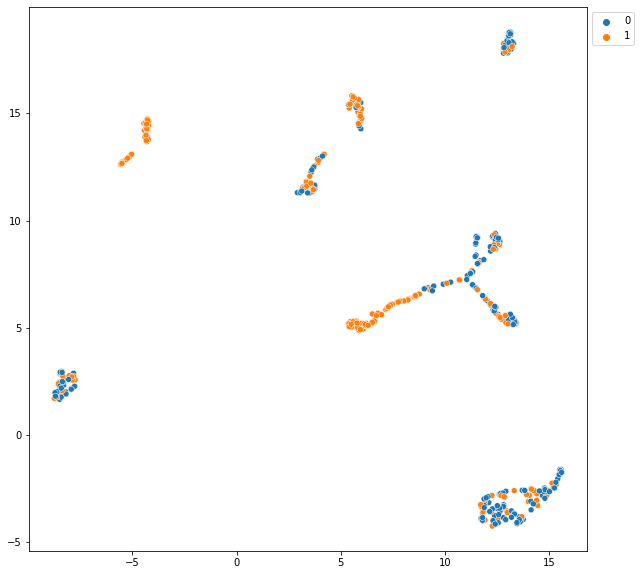

In [41]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data['user'].y[:,5].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.savefig("umap_embd_sage.png", dpi=120)

In [42]:
embd_x = umap.UMAP().fit_transform(data['user'].x.numpy())

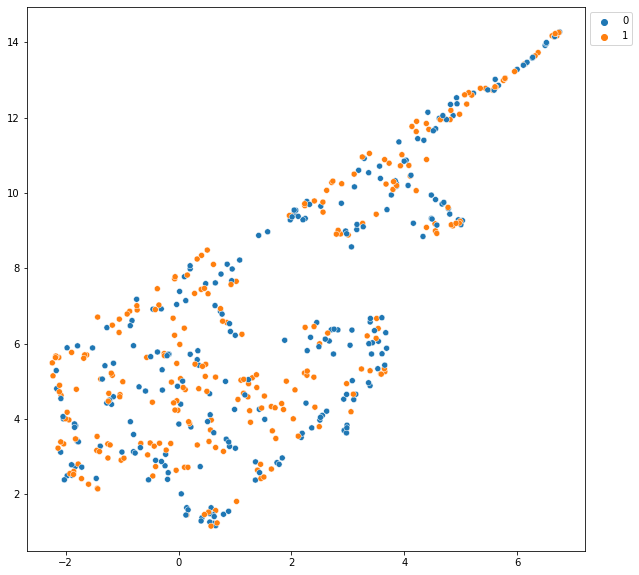

In [43]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data['user'].y[:,2].cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)

## Edge prediction

In [91]:
import scipy.sparse as sp

In [92]:
u, v = data['buys'].edge_index
data['buys'].edge_index

tensor([[  5,   8,  23,  ..., 494, 495, 496],
        [  0,   0,   0,  ...,   5,   5,   5]])

In [93]:
data.num_edges

1503

In [94]:
eids = np.arange(data.num_edges)
eids = np.random.permutation(eids)

In [95]:
test_size = int(len(eids) * 0.1)
train_size = data.num_edges - test_size

In [96]:
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

In [97]:
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))

In [104]:
adj_neg = 1 - adj.todense()
neg_u, neg_v = torch.tensor(np.where(adj_neg != 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  


In [105]:
type(adj)

scipy.sparse.coo.coo_matrix

In [106]:
neg_eids = np.random.choice(len(neg_u), data.num_edges)
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [ ]:
# # Split edge set for training and testing
# u, v = g.edges()

# eids = np.arange(g.number_of_edges())
# eids = np.random.permutation(eids)
# test_size = int(len(eids) * 0.1)
# train_size = g.number_of_edges() - test_size
# test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
# train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# # Find all negative edges and split them for training and testing
# adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
# adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
# neg_u, neg_v = np.where(adj_neg != 0)

# neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
# test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
# train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [43]:
# create new dataset for train & test

In [90]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1503] }
)

In [88]:
train_pos_g

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1365] }
)

In [117]:
# Надо добавить проверку на изолированные ноды
train_pos_g = data.clone()
train_pos_g['buys'].edge_index = torch.stack((train_pos_u, train_pos_v))
train_pos_g = T.ToUndirected()(train_pos_g)

train_neg_g = data.clone()
train_neg_g['buys'].edge_index = torch.stack((train_neg_u, train_neg_v))
train_neg_g = T.ToUndirected()(train_neg_g)

test_pos_g = data.clone()
test_pos_g['buys'].edge_index = torch.stack((test_pos_u, test_pos_v))
test_pos_g = T.ToUndirected()(test_pos_g)

test_neg_g = data.clone()
test_neg_g['buys'].edge_index = torch.stack((test_neg_u, test_neg_v))
test_neg_g = T.ToUndirected()(test_neg_g)

In [54]:
data

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1365] }
)

In [103]:
train_pos_u

tensor([237, 310, 457,  ..., 119, 295,   2])

In [102]:
train_neg_u

array([257, 331, 416, ..., 237, 115,  88])

In [52]:
torch.stack((train_pos_u, train_pos_v)).shape

torch.Size([2, 1365])

In [110]:
# train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
# train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

# test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
# test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [115]:
data = T.ToUndirected()(data)

In [116]:
class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64)
model = to_hetero(model, data.metadata(), aggr='sum')

In [ ]:
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [ ]:
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

In [118]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
#optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in loader:
            optimizer.zero_grad()
            #batch = batch.to('cuda:0')
            batch_size = batch['user'].batch_size
            #print(batch['user'].y)

            out = model(batch.x_dict,
                        batch.edge_index_dict)
            #break

            ### negative sampling
            neg_dish = []
            for element in batch['user'].y[:batch_size]:
              list_ = np.where(element == 0)[0]
              if list_ != []:
                neg_dish.append(np.random.choice(list_))
              else: 
                neg_dish.append(np.random.choice(np.arange(len(element))))
      
            n_neigh = 10
            dish_loader = NeighborLoader(
                hetero_data,
                # Sample n_neigh neighbors for each node and edge type for 2 iterations
                num_neighbors={key: [n_neigh] * 1 for key in hetero_data.edge_types},
                # Use a batch size of 128 for sampling training nodes of type paper
                batch_size=1,
                input_nodes=('dish', torch.Tensor(neg_dish)),
            )
            for dish_batch in dish_loader:
              optimizer.zero_grad()
              #batch = batch.to('cuda:0')
              batch_size = dish_batch['dish'].batch_size

              neg_out = model(dish_batch.x_dict,
                            dish_batch.edge_index_dict)


            # loss = F.cross_entropy(out['paper'][:batch_size],
            #                        batch['paper'].y[:batch_size])
            #print(out['user'][:batch_size])
            pos_loss = F.logsigmoid((out['user'][:batch_size] * out['dish'][:batch_size]).sum(-1)).mean()
            neg_loss = F.logsigmoid(-(out['user'][:batch_size] * neg_out['dish'][:batch_size]).sum(-1)).mean()
            loss = -pos_loss - neg_loss
            loss.backward()
            optimizer.step()

            total_examples += batch_size
            total_loss += float(loss) * batch_size
    return total_loss / total_examples

In [125]:
out = model(data.x_dict,
                    data.edge_index_dict)

In [124]:
out['dish'].shape, out['user'].shape

(torch.Size([6, 64]), torch.Size([500, 64]))

In [131]:
train_pos_g

HeteroData(
  user={
    x=[500, 6],
    y=[500, 6]
  },
  dish={ x=[6, 6] },
  (user, buys, dish)={ edge_index=[2, 1353] },
  (dish, rev_buys, user)={ edge_index=[2, 1353] },
  (user, rev_rev_buys, dish)={ edge_index=[2, 1353] }
)

In [144]:
train_pos_g['user'].x[train_pos_g['buys'].edge_index[0]]

tensor([[0.8581, 0.7142, 0.5043, 0.7363, 0.5043, 0.7363],
        [0.5655, 0.5004, 0.3566, 0.9385, 0.3566, 0.9385],
        [0.8210, 0.5581, 0.4331, 0.7570, 0.4331, 0.7570],
        ...,
        [0.7169, 0.3709, 0.4905, 0.8217, 0.4905, 0.8217],
        [0.0697, 0.7087, 0.3028, 1.7553, 0.3028, 1.7553],
        [0.6233, 0.3659, 0.5151, 0.8903, 0.5151, 0.8903]])

In [141]:
train_pos_g['dish'].x[train_pos_g['buys'].edge_index[1]]

tensor([[0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.]])

In [145]:
train_pos_g['user'].x[train_pos_g['buys'].edge_index[0]] * train_pos_g['dish'].x[train_pos_g['buys'].edge_index[1]]

tensor([[0.0000, 0.0000, 0.5043, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.3566, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7570],
        ...,
        [0.0000, 0.3709, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3028, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8903, 0.0000, 0.0000]])

In [ ]:
# full batch example:
model.train()

total_examples = total_loss = 0
for _ in range(5):
        optimizer.zero_grad()
        #batch = batch.to('cuda:0')
        batch_size = data['user'].batch_size
        #print(batch['user'].y)

        out = model(data.x_dict,
                    data.edge_index_dict)
        
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        loss.backward()
        optimizer.step()
        if e % 5 == 0:
            print('In epoch {}, loss: {}'.format(e, loss))
            print('In epoch {}, val loss: {}'.format(e, val_loss))

In [ ]:
# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    #
    with torch.no_grad():
      pos_score = pred(test_pos_g, h)
      neg_score = pred(test_neg_g, h)
      val_loss = compute_loss(pos_score, neg_score)
      #print(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
        print('In epoch {}, val loss: {}'.format(e, val_loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

### Работа с визуализацией

In [ ]:
homogeneous_data = data.to_homogeneous()
print(homogeneous_data)

import torch_geometric
import networkx as nx

g = torch_geometric.utils.to_networkx(homogeneous_data, to_undirected=True)

Data(node_type=[206], x=[206, 7], edge_index=[2, 1240], edge_type=[1240])


In [ ]:
homogeneous_data.node_type

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1])

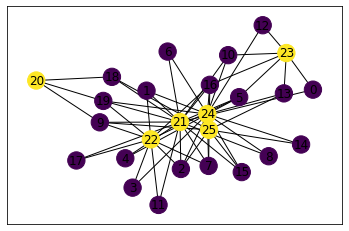

In [ ]:
nx.draw_networkx(g, node_color = homogeneous_data.node_type,)

In [ ]:
!pip install pygraphviz

  Using cached pygraphviz-1.7.zip (118 kB)
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165743 sha256=026599c27849b406bde8a4b6b463764d95114075cd66854595cfc0c8375282f2
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [ ]:
!pip install dgl
import dgl

     |████████████████████████████████| 4.4 MB 7.8 MB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
G = dgl.heterograph({
        ('user', 'buys', 'dish') : (np.array(data['buys'].edge_index[0]),np.array(data['buys'].edge_index[1]))
    })

print(G)

Graph(num_nodes={'dish': 3, 'user': 3},
      num_edges={('user', 'buys', 'dish'): 4},
      metagraph=[('user', 'dish', 'buys')])


In [ ]:
G

Graph(num_nodes={'dish': 3, 'user': 3},
      num_edges={('user', 'buys', 'dish'): 4},
      metagraph=[('user', 'dish', 'buys')])

In [ ]:
# Draw the metagraph using graphviz.
import pygraphviz as pgv

def plot_graph(nxg):
    ag = pgv.AGraph(strict=False, directed=True)
    for u, v, k in nxg.edges(keys=True):
        ag.add_edge(u, v, label=k)
    ag.layout('dot')
    ag.draw('graph.png')

plot_graph(G.metagraph())

AttributeError: ignored

### Конец визуализации

In [ ]:
class SAGE(nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
              self.convs.append(SAGEConv((-1, -1), hidden_channels))
            else:
              self.convs.append(SAGEConv(hidden_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

In [ ]:
class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            #print(x, x_target)
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

### https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html

In [29]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero


dataset = OGB_MAG(root='./data', preprocess='metapath2vec', transform=T.ToUndirected())
data = dataset[0]

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


model = GNN(hidden_channels=64, out_channels=dataset.num_classes)
model = to_hetero(model, data.metadata(), aggr='sum')

In [28]:
model.to(device)

NameError: ignored

In [30]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.loader import NeighborLoader

transform = T.ToUndirected()  # Add reverse edge types.
data = OGB_MAG(root='./data', preprocess='metapath2vec', transform=transform)[0]

train_loader = NeighborLoader(
    data,
    # Sample 15 neighbors for each node and each edge type for 2 iterations:
    num_neighbors=[5] * 2,
    # Use a batch size of 128 for sampling training nodes of type "paper":
    batch_size=128,
    input_nodes=('paper', data['paper'].train_mask),
)

batch_ = next(iter(train_loader))

In [7]:
def train():
    model.train()

    total_examples = total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to('cuda:0')
        batch_size = batch['paper'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)
        loss = F.cross_entropy(out['paper'][:batch_size],
                               batch['paper'].y[:batch_size])
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

In [15]:
for _ in range(5):
  loss = train()
  print(loss)

2.460340871522056
2.421613215654865
2.418862276977774
2.4105351814238567
2.408808349571423


### [Link Prediction using Graph Neural Networks (dgl)](https://docs.dgl.ai/en/0.7.x/tutorials/blitz/4_link_predict.html)

In [3]:
#!pip3 install dgl
!pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install torch==1.9.1
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 6.2 MB 4.0 MB/s 
     |████████████████████████████████| 831.4 MB 6.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.9.1 which is incompatible.


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [111]:
torch.__version__

'1.11.0+cu113'

In [5]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [6]:
g

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64)})

In [7]:
# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

In [8]:
g.edges()

(tensor([   3,    5,    6,  ..., 2704, 2707, 2706]),
 tensor([   0,    0,    0,  ..., 2705, 2706, 2707]))

In [9]:
train_g = dgl.remove_edges(g, eids[:test_size])

In [10]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [11]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [12]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [46]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [47]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
pred = MLPPredictor(16)
#pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [48]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    #
    with torch.no_grad():
      pos_score = pred(test_pos_g, h)
      neg_score = pred(test_neg_g, h)
      val_loss = compute_loss(pos_score, neg_score)
      #print(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))
        print('In epoch {}, val loss: {}'.format(e, val_loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.6938760876655579
In epoch 0, val loss: 0.6939792037010193
In epoch 5, loss: 0.6852141618728638
In epoch 5, val loss: 0.6876188516616821
In epoch 10, loss: 0.6542459726333618
In epoch 10, val loss: 0.6652452945709229
In epoch 15, loss: 0.60013347864151
In epoch 15, val loss: 0.644220769405365
In epoch 20, loss: 0.5649135112762451
In epoch 20, val loss: 0.668952226638794
In epoch 25, loss: 0.5449780225753784
In epoch 25, val loss: 0.6750961542129517
In epoch 30, loss: 0.5261843204498291
In epoch 30, val loss: 0.6616355776786804
In epoch 35, loss: 0.5106895565986633
In epoch 35, val loss: 0.6624982953071594
In epoch 40, loss: 0.4966072738170624
In epoch 40, val loss: 0.6740617156028748
In epoch 45, loss: 0.4823524057865143
In epoch 45, val loss: 0.6878910064697266
In epoch 50, loss: 0.4679039716720581
In epoch 50, val loss: 0.7049121856689453
In epoch 55, loss: 0.4526805579662323
In epoch 55, val loss: 0.7203114628791809
In epoch 60, loss: 0.434589684009552
In epoch 60

In [17]:
h.shape

torch.Size([2708, 16])

In [27]:
train_pos_g

Graph(num_nodes=2708, num_edges=9501,
      ndata_schemes={}
      edata_schemes={})

In [23]:
pos_score = pred(train_pos_g, h)

In [28]:
g.ndata['h'] = h
# Compute a new edge feature named 'score' by a dot-product between the
# source node feature 'h' and destination node feature 'h'.
g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
# u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
#return g.edata['score'][:, 0]

In [31]:
h.shape

torch.Size([2708, 16])

In [33]:
g.edata['score'].shape

torch.Size([10556, 1])

### [Link Prediction Recommendation Engines with Node2Vec](https://towardsdatascience.com/link-prediction-recommendation-engines-with-node2vec-c97c429351a8)

In [4]:
!pip3 install arxiv
!pip3 install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=02a5d0d199dd25dfadd897f93f247ccee8d797c4d5ab6f3119e279b411fd4c36
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [8]:
import networkx as nx
import pandas as pd
import numpy as np
import arxiv

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec as n2v

# constants
queries = [
    'automl', 'machinelearning', 'data', 'phyiscs','mathematics', 'recommendation system', 'nlp', 'neural networks'
]

def search_arxiv(queries, max_results = 100):
    '''
    This function will search arxiv associated to a set of queries and store
    the latest 10000 (max_results) associated to that search.
    
    params:
        queries (List -> Str) : A list of strings containing keywords you want
                                to search on Arxiv
        max_results (Int) : The maximum number of results you want to see associated
                            to your search. Default value is 1000, capped at 300000
                            
    returns:
        This function will return a DataFrame holding the following columns associated
        to the queries the user has passed. 
            `title`, `date`, `article_id`, `url`, `main_topic`, `all_topics`
    
    example:
        research_df = search_arxiv(
            queries = ['automl', 'recommender system', 'nlp', 'data science'],
            max_results = 10000
        )
    '''
    d = []
    searches = []
    # hitting the API
    for query in queries:
        search = arxiv.Search(
          query = query,
          max_results = max_results,
          sort_by = arxiv.SortCriterion.SubmittedDate,
          sort_order = arxiv.SortOrder.Descending
        )
        searches.append(search)
    
    # Converting search result into df
    for search in searches:
        for res in search.results():
            data = {
                'title' : res.title,
                'date' : res.published,
                'article_id' : res.entry_id,
                'url' : res.pdf_url,
                'main_topic' : res.primary_category,
                'all_topics' : res.categories,
                'authors' : res.authors
            }
            d.append(data)
        
    d = pd.DataFrame(d)
    d['year'] = pd.DatetimeIndex(d['date']).year
    
    # change article id from url to integer
    unique_article_ids = d.article_id.unique()
    article_mapping = {art:idx for idx,art in enumerate(unique_article_ids)}
    d['article_id'] = d['article_id'].map(article_mapping)
    return d
  
research_df = search_arxiv(
    queries = queries,
    max_results = 200
)
print(research_df.shape)

(1246, 8)


In [9]:
def generate_network(df, node_col = 'article_id', edge_col = 'main_topic'):
    '''
    This function will generate a article to article network given an input DataFrame.
    It will do so by creating an edge_dictionary where each key is going to be a node
    referenced by unique values in node_col and the values will be a list of other nodes
    connected to the key through the edge_col.
    
    params:
        df (DataFrame) : The dataset which holds the node and edge columns
        node_col (String) : The column name associated to the nodes of the network
        edge_col (String) : The column name associated to the edges of the network
        
    returns:
        A networkx graph corresponding to the input dataset
        
    example:
        generate_network(
            research_df,
            node_col = 'article_id',
            edge_col = 'main_topic'
        )
    '''
    edge_dct = {}
    for i,g in df.groupby(node_col):
        topics = g[edge_col].unique()
        edge_df = df[(df[node_col] != i) & (df[edge_col].isin(topics))]
        edges = list(edge_df[node_col].unique())
        edge_dct[i] = edges
    
    # create nx network
    g = nx.Graph(edge_dct, create_using = nx.MultiGraph)
    return g
  
all_tp = research_df.explode('all_topics').copy()

tp_nx = generate_network(
    all_tp, 
    node_col = 'article_id', 
    edge_col = 'all_topics'
)

print(nx.info(tp_nx))

Graph with 1099 nodes and 100345 edges
